In [1]:
# import warnings
import rpy2
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from os import path, makedirs
from glob import glob
from statsmodels.stats.anova import AnovaRM
from rpy2.robjects.packages import importr
# import rpy2

    
from utils import formats, full_passed_turkers, DATA_DIR
from utils import read_cond_file, violation_analysis, get_attr, calc_SSRT, filter_ssrt_subs, get_p_str, ssrt_comparison
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
try:
    BayesFactor = importr('BayesFactor')
except:
    utils = importr('utils')
    utils.install_packages('BayesFactor', repo="http://cran.rstudio.com/")
    BayesFactor = importr('BayesFactor')
    
try:
    rstatix = importr('rstatix')
except:
    utils = importr('utils')
    utils.install_packages('rstatix', repo="http://cran.rstudio.com/") 
    rstatix = importr('rstatix')
    
# try:
#     phia = importr('phia')
# except:
#     utils = importr('utils')
#     utils.install_packages('phia', repo="http://cran.rstudio.com/") 
#     phia = importr('phia')

In [3]:
JASP_DIR = 'Fig3Jasp'
makedirs(JASP_DIR, exist_ok=True)
F2_INPUT_DIR = path.join(JASP_DIR, 'Input')
makedirs(F2_INPUT_DIR, exist_ok=True)

# Helper Functions

In [4]:
def get_attr(rout, attr='bf'):
    # Takes in an rpy2 vector, returns the value of an attribute
    # Used for BayesFactor
        try:
            index = list(rout.names).index(attr)
            val = list(rout.items())[index][1]
            if len(val) == 1:
                val = val[0]
            if type(val)==rpy2.robjects.vectors.Matrix:
                val = np.asarray(val)
            return val
        except ValueError:
            print('Did not pass a valid attribute')

In [5]:
def get_mean_corr_RT(sub_df, trial_type=''):
    assert((trial_type=='GoCritical') | (trial_type=='GoNoncritical') | (trial_type=='Go'))

    # get relevant columns
    rt_col = trial_type+'RT'
    response_col = trial_type+'TrialResponse'
    corr_resp_col = trial_type+'TrialCorrectResponse'
    
    #convert to columns to string but leave nans alone
    sub_df[response_col] = np.where(pd.isnull(sub_df[response_col]),sub_df[response_col],sub_df[response_col].astype(str))
    sub_df[corr_resp_col] = np.where(pd.isnull(sub_df[corr_resp_col]),sub_df[corr_resp_col],sub_df[corr_resp_col].astype(str))
    
    #subset to correct answers
    correct_trials = sub_df[sub_df[response_col].str.lower()==sub_df[corr_resp_col].str.lower()] 
    #take mean of correct RTs
    mean_rt = correct_trials[rt_col].mean()

    return(mean_rt)

In [6]:
def get_acc(sub_df, trial_type=''):
    assert((trial_type=='GoCritical') | (trial_type=='GoNoncritical') | (trial_type=='Go') | (trial_type=='Stop'))
    
    # get relevant columns
    response_col = trial_type+'TrialResponse'
    corr_resp_col = trial_type+'TrialCorrectResponse'
    #convert to columns to string but leave nans alone
    sub_df[response_col] = np.where(pd.isnull(sub_df[response_col]),sub_df[response_col],sub_df[response_col].astype(str))
    sub_df[corr_resp_col] = np.where(pd.isnull(sub_df[corr_resp_col]),sub_df[corr_resp_col],sub_df[corr_resp_col].astype(str))
    if 'Go' in trial_type:
        num_trials = sub_df.loc[sub_df['TrialType'].str.lower()==trial_type.lower(), 'TrialType'].count()
        num_corr_trials = sub_df.loc[sub_df[response_col].str.lower()==sub_df[corr_resp_col].str.lower(),
                                    'TrialType'].count()
    else: #if stop, only take the trials that have a response as your total # of trials
        num_trials = sub_df.loc[(sub_df['TrialType'].str.lower()==trial_type.lower()) & (sub_df['StopTrialResponse'].notnull()), 'TrialType'].count()
        num_corr_trials = sub_df.loc[sub_df[response_col].str.lower()==sub_df[corr_resp_col].str.lower(),
                                    'TrialType'].count()

    return(num_corr_trials/num_trials)

In [7]:
def get_P_resp_per_ssd(sub_df, ssds):
    P_respond_per_ssd = []
    for ssd in ssds:
        stop_trials = sub_df.loc[sub_df.StopSignalDelay==ssd, 'StopFailureRT']
        stop_fails = stop_trials > 0
        p_respond = stop_fails.sum() / stop_trials.count()
        P_respond_per_ssd.append(p_respond)
    return(np.asarray(P_respond_per_ssd))

In [8]:
def mk_anova_df(cond_dfs, labels, goRTKey = 'GoRT', goTrialKey='Go'):
    no_stop_RTs = []
    corrGo_RTs = []
    stopFail_RTs = []
    go_accs = []
    p_responds = []
    subjects = []
    conditions = []
    for cond_df, condition  in zip(cond_dfs, labels):
        go_RT = 'GoRT'
        go_trial='Go'
        if 'GoCriticalRT' in cond_df.columns:
            go_RT = 'GoCriticalRT'
            go_trial = 'GoCritical'
        all_subjects = cond_df.Subject.unique()
        if len(all_subjects)==522: #if turk sample, swap out all subjects
            all_subjects = full_passed_turkers
        for subject in all_subjects:
            subdata = cond_df.query('Subject == %d' % subject).copy()
            #no-stop-signal RTs
            curr_RT = subdata.loc[subdata[go_RT]>0, go_RT].mean()
            no_stop_RTs.append(curr_RT)
            #correct go RTs
            curr_corrGo_RT = get_mean_corr_RT(subdata, trial_type=go_trial)
            corrGo_RTs.append(curr_corrGo_RT)
            #stop failure RT
            curr_stopFail_RT = subdata.loc[subdata['StopFailureRT']>0, 'StopFailureRT'].mean()
            stopFail_RTs.append(curr_stopFail_RT)
            #go accuracy
            curr_acc = get_acc(subdata, trial_type=go_trial)
            go_accs.append(curr_acc)
            #P (respond | signal)
            stop_trials = subdata.loc[subdata.StopSignalDelay.notnull(), 'StopFailureRT']
            stop_fails = stop_trials > 0 #find times when RT > 0 i.e. they responded
            p_respond = stop_fails.sum() / stop_trials.count() #boolean aray vs series count fun
            p_responds.append(p_respond)
            #Note keeping
            subjects.append(subject)
            conditions.append(condition)

    out_df = pd.DataFrame({'goRT': no_stop_RTs, 'corrGoRT': corrGo_RTs, 'GoACC': go_accs, 'stopFailRT': stopFail_RTs, 'p_respond': p_responds, 'subject': subjects, 'condition': conditions})
    return out_df


# __Run Violational Analyses__

In [9]:
# get the various data files to analysis
condition_files = glob(path.join(DATA_DIR, 'Data*'))
condition_files = [filey for filey in condition_files if 'Matzke' not in filey]
condition_files.sort()
condition_files += ['Data/DataMatzke.xlsx'] #append Matzke data to keep preprint's order

#for each data file, analyze and save the results
for condition_file in condition_files:
    _ = violation_analysis(condition_file, save_results=True, verbose=False)

# __Supplementary Analyses__

# __Fast vs Slow subjects (Condition 1)__

In [10]:
cond1_df = read_cond_file('Data/DataFixedSSDs1.xlsx')

In [11]:
cond1_ssds = ssdvals = [i for i in cond1_df.StopSignalDelay.unique() if isinstance(i, float) and i==i]
cond1_ssds.sort()

cond1_go_RTs = []
cond1_go_accs = []
cond1_stopFail_RTs = []
cond1_allGo_RTs = []
cond1_P_resp_per_ssd = []

for subject in cond1_df.Subject.unique():
    subdata = cond1_df.query('Subject == %d' % subject).copy()
    #correct go RT
    curr_corrGo_RT = get_mean_corr_RT(subdata, trial_type='Go')
    cond1_go_RTs.append(curr_corrGo_RT)
    #go accuracy
    curr_acc = get_acc(subdata, trial_type='Go')
    cond1_go_accs.append(curr_acc)
    #stop failure RT
    curr_stopFail_RT = subdata.loc[subdata['StopFailureRT']>0, 'StopFailureRT'].mean()
    cond1_stopFail_RTs.append(curr_stopFail_RT)
    #go RT
    curr_allGo_RT = subdata.loc[subdata['GoRT']>0, 'GoRT'].mean()
    cond1_allGo_RTs.append(curr_allGo_RT)
    #P(repsond|signal)
    curr_P_resp = get_P_resp_per_ssd(subdata, cond1_ssds)
    cond1_P_resp_per_ssd.append(curr_P_resp)
    
    
print(f'Mean correct Go RT = {np.mean(cond1_go_RTs): .0f}ms')
print(f'Mean Go Accuracy = {np.mean(cond1_go_accs): .1%}')
print(f'Mean stop failure RT = {np.mean(cond1_stopFail_RTs): .0f}ms')
print(f'Mean Go RT  = {np.mean(cond1_allGo_RTs): .0f}ms')

t, p = stats.ttest_1samp(np.asarray(cond1_allGo_RTs)-np.asarray(cond1_stopFail_RTs), 0)
print(f'''Mean stop-failure RT was {np.mean(cond1_stopFail_RTs):.0f}ms, which was significantly shorter
than mean no-stop-signal RT excluding omissions (M = {np.mean(cond1_allGo_RTs):.0f}ms), t({len(cond1_allGo_RTs)-1})={t: .2f}, p<{np.maximum(0.001, p)})''')

p_resp_per_ssd_df = pd.DataFrame(np.asarray(cond1_P_resp_per_ssd).T, index=cond1_ssds, columns=cond1_df.Subject.unique())

p_resp_per_ssd_series = p_resp_per_ssd_df.mean(1)
p_resp_per_ssd_series.index.name='SSD'
p_resp_per_ssd_series.name = 'P(respond|signal)'
print('-'*26)
print('SSD || P(respond | signal)')
print('-'*26)
for ssd in p_resp_per_ssd_series.index:
    print(f'{ssd} || {p_resp_per_ssd_series[ssd]: .02f}')
print('-'*26)


# stopFail_df = subdata.loc[subdata['StopFailureRT']>0, ['GoTrialCorrectResponse', 'StopTrialResponse']]

Mean correct Go RT =  490ms
Mean Go Accuracy =  94.1%
Mean stop failure RT =  469ms
Mean Go RT  =  489ms
Mean stop-failure RT was 469ms, which was significantly shorter
than mean no-stop-signal RT excluding omissions (M = 489ms), t(23)= 5.81, p<0.001)
--------------------------
SSD || P(respond | signal)
--------------------------
100.0 ||  0.24
200.0 ||  0.36
300.0 ||  0.64
400.0 ||  0.86
500.0 ||  0.95
--------------------------


# choice accuracy on stop-failure trials at different SSDs

In [12]:
cond1_addon_file = 'Data/FixedSSD1StopTrialChoiceAccuracyInput.xlsx'
cond1_addon_df = pd.read_excel(cond1_addon_file)

In [13]:
#build up "correct" responses for stop trials
cond1_df['StopTrialCorrectResponse'] = np.nan

# circle response
cond1_df.loc[(cond1_df['TrialType']=='stop') & (cond1_addon_df['Image[SubTrial]']=='circle.bmp'), 'StopTrialCorrectResponse'] = \
cond1_addon_df.loc[(cond1_df['TrialType']=='stop') & (cond1_addon_df['Image[SubTrial]']=='circle.bmp'), 'CircleResponse']

# rhombus response
cond1_df.loc[(cond1_df['TrialType']=='stop') & (cond1_addon_df['Image[SubTrial]']=='rhombus.bmp'), 'StopTrialCorrectResponse'] = \
cond1_addon_df.loc[(cond1_df['TrialType']=='stop') & (cond1_addon_df['Image[SubTrial]']=='rhombus.bmp'), 'RhombusResponse']

# square response
cond1_df.loc[(cond1_df['TrialType']=='stop') & (cond1_addon_df['Image[SubTrial]']=='square.bmp'), 'StopTrialCorrectResponse'] = \
cond1_addon_df.loc[(cond1_df['TrialType']=='stop') & (cond1_addon_df['Image[SubTrial]']=='square.bmp'), 'SquareResponse']

# triangle response
cond1_df.loc[(cond1_df['TrialType']=='stop') & (cond1_addon_df['Image[SubTrial]']=='triangle.bmp'), 'StopTrialCorrectResponse'] = \
cond1_addon_df.loc[(cond1_df['TrialType']=='stop') & (cond1_addon_df['Image[SubTrial]']=='triangle.bmp'), 'TriangleResponse']


#Get accuracies for subsets of SSDs
fullSSD_stopAcc = []
shortSSD_stopAcc = []
longSSD_stopAcc = []
for subject in cond1_df.Subject.unique():
    subdata = cond1_df.query('Subject == %d' % subject).copy()
    full_stopAcc = get_acc(subdata, trial_type='Stop')
    fullSSD_stopAcc.append(full_stopAcc)
    short_stopAcc = get_acc(subdata.loc[(subdata['StopSignalDelay']<200) | (subdata['StopSignalDelay'].isnull()), :].copy(),
                            trial_type='Stop')
    shortSSD_stopAcc.append(short_stopAcc)
    long_stopAcc = get_acc(subdata.loc[(subdata['StopSignalDelay']>=200) | (subdata['StopSignalDelay'].isnull()), :].copy(),
                           trial_type='Stop')
    longSSD_stopAcc.append(long_stopAcc) 

print(f'Choice accuracy on stop-failure trials at short SSDs = {np.mean(shortSSD_stopAcc):.1%}')
print(f'Choice accuracy on stop-failure trials at long SSDs = {np.mean(longSSD_stopAcc):.1%}')
print(f'Choice accuracy on stop-failure trials at all SSDs = {np.mean(fullSSD_stopAcc):.1%}')

t_diff, p_diff = stats.ttest_1samp(np.asarray(shortSSD_stopAcc)-np.asarray(longSSD_stopAcc), 0)
t_full, p_full = stats.ttest_1samp(np.asarray(shortSSD_stopAcc)-np.asarray(fullSSD_stopAcc), 0)
print(f'''Choice accuracy on stop-failure trials at short SSDs (SSD <200ms, M accuracy = {np.mean(shortSSD_stopAcc):.1%})
was not lower than at longer SSDs (SSD >= 200ms, M accuracy = {np.mean(longSSD_stopAcc):.1%}, t({len(longSSD_stopAcc)-1})={t_diff:.02f}, {get_p_str(p_diff)})
or overall no-stop-signal accuracy (M = {np.mean(fullSSD_stopAcc):.1%}, t({len(fullSSD_stopAcc)-1})={t_full:.02f}, {get_p_str(p_full)})''')

Choice accuracy on stop-failure trials at short SSDs = 95.1%
Choice accuracy on stop-failure trials at long SSDs = 93.8%
Choice accuracy on stop-failure trials at all SSDs = 94.0%
Choice accuracy on stop-failure trials at short SSDs (SSD <200ms, M accuracy = 95.1%)
was not lower than at longer SSDs (SSD >= 200ms, M accuracy = 93.8%, t(23)=0.70, p = 0.49)
or overall no-stop-signal accuracy (M = 94.0%, t(23)=0.64, p = 0.53)


## SSRT x SSD 

In [14]:
ssrt_comparison([cond1_df], ['Fixed SSD 1'])

Fixed SSD 1
0 subject(s) excluded from Fixed SSD 1
Overall SSRT (M = 200 ms) was significantly slower than SSRT with short SSDs excluded (M = 179 ms),
t(23) = 8.89, p < 0.001
********************************************************************************


In [15]:
del cond1_df

# __Fast versus Slow Subjects (Condition 2)__

In [16]:
# read in cond2 and add on StopTrialCorrectResponse
cond2_df = read_cond_file('Data/DataFixedSSDs2.xlsx')

cond2_addon_file = 'Data/FixedSSD2StopTrialChoiceAccuracyInput.xlsx'
cond2_addon_df = pd.read_excel(cond2_addon_file)

In [17]:
#build up "correct" responses for stop trials
cond2_df['StopTrialCorrectResponse'] = np.nan

# circle response
cond2_df.loc[(cond2_df['TrialType']=='stop') & (cond2_addon_df['Unnamed: 5']=='circle.bmp'), 'StopTrialCorrectResponse'] = \
cond2_addon_df.loc[(cond2_df['TrialType']=='stop') & (cond2_addon_df['Unnamed: 5']=='circle.bmp'), 'CircleResponse']

# rhombus response
cond2_df.loc[(cond2_df['TrialType']=='stop') & (cond2_addon_df['Unnamed: 5']=='rhombus.bmp'), 'StopTrialCorrectResponse'] = \
cond2_addon_df.loc[(cond2_df['TrialType']=='stop') & (cond2_addon_df['Unnamed: 5']=='rhombus.bmp'), 'RhombusResponse']

# square response
cond2_df.loc[(cond2_df['TrialType']=='stop') & (cond2_addon_df['Unnamed: 5']=='square.bmp'), 'StopTrialCorrectResponse'] = \
cond2_addon_df.loc[(cond2_df['TrialType']=='stop') & (cond2_addon_df['Unnamed: 5']=='square.bmp'), 'SquareResponse']

# triangle response
cond2_df.loc[(cond2_df['TrialType']=='stop') & (cond2_addon_df['Unnamed: 5']=='triangle.bmp'), 'StopTrialCorrectResponse'] = \
cond2_addon_df.loc[(cond2_df['TrialType']=='stop') & (cond2_addon_df['Unnamed: 5']=='triangle.bmp'), 'TriangleResponse']

In [18]:
cond2_ssds = ssdvals = [i for i in cond2_df.StopSignalDelay.unique() if isinstance(i, float) and i==i]
cond2_ssds.sort()

cond2_go_RTs = []
cond2_go_accs = []
cond2_stopFail_RTs = []
cond2_allGo_RTs = []
cond2_P_resp_per_ssd = []

for subject in cond2_df.Subject.unique():
    subdata = cond2_df.query('Subject == %d' % subject).copy()
    #correct go RT
    curr_corrGo_RT = get_mean_corr_RT(subdata, trial_type='Go')
    cond2_go_RTs.append(curr_corrGo_RT)
    #go accuracy
    curr_acc = get_acc(subdata, trial_type='Go')
    cond2_go_accs.append(curr_acc)
    #stop failure RT
    curr_stopFail_RT = subdata.loc[subdata['StopFailureRT']>0, 'StopFailureRT'].mean()
    cond2_stopFail_RTs.append(curr_stopFail_RT)
    #go RT
    curr_allGo_RT = subdata.loc[subdata['GoRT']>0, 'GoRT'].mean()
    cond2_allGo_RTs.append(curr_allGo_RT)
    #P(repsond|signal)
    curr_P_resp = get_P_resp_per_ssd(subdata, cond2_ssds)
    cond2_P_resp_per_ssd.append(curr_P_resp)
    
    
print(f'Mean correct Go RT = {np.mean(cond2_go_RTs): .0f}ms')
print(f'Mean Go Accuracy = {np.mean(cond2_go_accs): .1%}')
print(f'Mean stop failure RT = {np.mean(cond2_stopFail_RTs): .0f}ms')
print(f'Mean Go RT  = {np.mean(cond2_allGo_RTs): .0f}ms')

t, p = stats.ttest_1samp(np.asarray(cond2_allGo_RTs)-np.asarray(cond2_stopFail_RTs), 0)
print('*'*79)
print(f'''Mean stop-failure RT was {np.mean(cond2_stopFail_RTs):.0f}ms, which was significantly shorter
than mean no-stop-signal RT excluding omissions (M = {np.mean(cond2_allGo_RTs):.0f}ms), t({len(cond2_allGo_RTs)-1})={t: .2f}, p<{np.maximum(0.001, p)})''')

p_resp_per_ssd_df = pd.DataFrame(np.asarray(cond2_P_resp_per_ssd).T, index=cond2_ssds, columns=cond2_df.Subject.unique())

p_resp_per_ssd_series = p_resp_per_ssd_df.mean(1)
p_resp_per_ssd_series.index.name='SSD'
p_resp_per_ssd_series.name = 'P(respond|signal)'
print('-'*26)
print('SSD || P(respond | signal)')
print('-'*26)
for ssd in p_resp_per_ssd_series.index:
    print(f'{ssd} || {p_resp_per_ssd_series[ssd]: .02f}')
print('-'*26)


# stopFail_df = subdata.loc[subdata['StopFailureRT']>0, ['GoTrialCorrectResponse', 'StopTrialResponse']]

Mean correct Go RT =  473ms
Mean Go Accuracy =  94.8%
Mean stop failure RT =  456ms
Mean Go RT  =  472ms
*******************************************************************************
Mean stop-failure RT was 456ms, which was significantly shorter
than mean no-stop-signal RT excluding omissions (M = 472ms), t(23)= 3.81, p<0.001)
--------------------------
SSD || P(respond | signal)
--------------------------
0.0 ||  0.20
50.0 ||  0.22
100.0 ||  0.24
150.0 ||  0.34
200.0 ||  0.46
250.0 ||  0.60
300.0 ||  0.73
350.0 ||  0.82
400.0 ||  0.89
450.0 ||  0.92
500.0 ||  0.94
--------------------------


In [19]:
#Get accuracies for subsets of SSDs
fullSSD_stopAcc = []
shortSSD_stopAcc = []
longSSD_stopAcc = []
for subject in cond2_df.Subject.unique():
    subdata = cond2_df.query('Subject == %d' % subject).copy()
    full_stopAcc = get_acc(subdata, trial_type='Stop')
    fullSSD_stopAcc.append(full_stopAcc)
    sub200_df = subdata.loc[(subdata['StopSignalDelay']<200) | (subdata['StopSignalDelay'].isnull()), :].copy()
    short_stopAcc = get_acc(sub200_df, trial_type='Stop')
    shortSSD_stopAcc.append(short_stopAcc)
    geq200_df = subdata.loc[(subdata['StopSignalDelay']>=200) | (subdata['StopSignalDelay'].isnull()), :].copy()
    long_stopAcc = get_acc(geq200_df, trial_type='Stop')
    longSSD_stopAcc.append(long_stopAcc) 

print(f'Choice accuracy on stop-failure trials at short SSDs = {np.mean(shortSSD_stopAcc):.1%}')
print(f'Choice accuracy on stop-failure trials at long SSDs = {np.mean(longSSD_stopAcc):.1%}')
print(f'Choice accuracy on stop-failure trials at all SSDs = {np.mean(fullSSD_stopAcc):.1%}')

t_diff, p_diff = stats.ttest_1samp(np.asarray(shortSSD_stopAcc)-np.asarray(longSSD_stopAcc), 0)
t_full, p_full = stats.ttest_1samp(np.asarray(shortSSD_stopAcc)-np.asarray(fullSSD_stopAcc), 0)
print('*'*79)
print(f'''Choice accuracy on stop-failure trials at short SSDs (SSD <200ms, M accuracy = {np.mean(shortSSD_stopAcc):.1%})
was not lower than at longer SSDs (SSD >= 200ms, M accuracy = {np.mean(longSSD_stopAcc):.1%}, t({len(longSSD_stopAcc)-1})={t_diff:.02f}, {get_p_str(p_diff)})
or overall no-stop-signal accuracy (M = {np.mean(fullSSD_stopAcc):.1%}, t({len(fullSSD_stopAcc)-1})={t_full:.02f}, {get_p_str(p_full)})''')

Choice accuracy on stop-failure trials at short SSDs = 97.2%
Choice accuracy on stop-failure trials at long SSDs = 95.6%
Choice accuracy on stop-failure trials at all SSDs = 95.8%
*******************************************************************************
Choice accuracy on stop-failure trials at short SSDs (SSD <200ms, M accuracy = 97.2%)
was not lower than at longer SSDs (SSD >= 200ms, M accuracy = 95.6%, t(23)=1.92, p = 0.07)
or overall no-stop-signal accuracy (M = 95.8%, t(23)=1.75, p = 0.09)


## SSRT x SSD 

In [20]:
ssrt_comparison([cond2_df], ['Fixed SSDs 2'])

Fixed SSDs 2
0 subject(s) excluded from Fixed SSDs 2
Overall SSRT (M = 217 ms) was significantly slower than SSRT with short SSDs excluded (M = 185 ms),
t(23) = 4.81, p < 0.001
********************************************************************************


In [21]:
del cond2_df

# __Varying Go Response Deadlines (Conditions 3-8)__

In [22]:
cond3_df = read_cond_file('Data/DataDeadline1300ms.xlsx')
cond4_df = read_cond_file('Data/DataDeadline1500ms.xlsx')
cond5_df = read_cond_file('Data/DataDeadline1700ms.xlsx')
cond6_df = read_cond_file('Data/DataDeadline2300ms.xlsx')
cond7_df = read_cond_file('Data/DataDeadline2500ms.xlsx')
cond8_df = read_cond_file('Data/DataDeadline2700ms.xlsx')

#shifting subjects in conditions 6-8 to keep IDs unique for combined analyses
assert((cond3_df['Subject'].max()==cond4_df['Subject'].max()) & (cond4_df['Subject'].max()==cond5_df['Subject'].max()))

cond6_df['Subject'] = cond6_df['Subject'] + cond5_df['Subject'].max()
cond7_df['Subject'] = cond7_df['Subject'] + cond5_df['Subject'].max()
cond8_df['Subject'] = cond8_df['Subject'] + cond5_df['Subject'].max()

In [23]:
deadline_df = mk_anova_df([cond3_df, cond4_df, cond5_df, cond6_df, cond7_df, cond8_df], ['300', '500', '700', '300', '500', '700'])

conds345_pivot_df = pd.pivot_table(deadline_df, values=['goRT', 'GoACC', 'stopFailRT'], index=['condition'], aggfunc=np.mean)

# RT analysis
aovrm_rt = AnovaRM(deadline_df, 'goRT', 'subject', within=['condition'])
rt_res = aovrm_rt.fit()

print(f'''Correct no-stop-signal RT were {conds345_pivot_df.loc['300', 'goRT']:.0f} ms, {conds345_pivot_df.loc['500', 'goRT']:.0f} ms, and {conds345_pivot_df.loc['700', 'goRT']:.0f} ms in the 300 ms, 500 ms, and 700 ms deadline conditions,
respectively, F({rt_res.anova_table['Num DF'][0]}, {rt_res.anova_table['Den DF'][0]}) = {rt_res.anova_table['F Value'][0]:.1f}, {get_p_str(rt_res.anova_table['Pr > F'][0])}.''')

# Accuracy analysis
aovrm_acc = AnovaRM(deadline_df, 'GoACC', 'subject', within=['condition'])
acc_res = aovrm_acc.fit()
print(formats.BOLD + '*'*80 + formats.END)
print(f'''Go accuracy was {conds345_pivot_df.loc['300', 'GoACC']:.0%}, {conds345_pivot_df.loc['500', 'GoACC']:.0%}, and {conds345_pivot_df.loc['700', 'GoACC']:.0%} in the 300 ms, 500 ms, and 700 ms deadline conditions,
respectively, F({acc_res.anova_table['Num DF'][0]}, {acc_res.anova_table['Den DF'][0]}) = {acc_res.anova_table['F Value'][0]:.1f}, {get_p_str(acc_res.anova_table['Pr > F'][0])}.''')

# RT by Condition Analysis
RT_melt_df = pd.melt(deadline_df, id_vars=['subject', 'condition'], value_vars=['goRT', 'stopFailRT'], var_name='TrialType', value_name='RT')

Correct no-stop-signal RT were 336 ms, 402 ms, and 446 ms in the 300 ms, 500 ms, and 700 ms deadline conditions,
respectively, F(2.0, 94.0) = 185.0, p < 0.001.
********************************************************************************
Go accuracy was 70%, 84%, and 89% in the 300 ms, 500 ms, and 700 ms deadline conditions,
respectively, F(2.0, 94.0) = 208.1, p < 0.001.


In [24]:
%%R -i RT_melt_df -o tbl #RUN ANOVA

aovres <- anova_test(
  data = RT_melt_df, dv = RT, wid = subject,
    within = c(condition, TrialType),
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [25]:
tbl = tbl.set_index('Effect')

groupCondition_df = deadline_df.groupby('condition').mean()
diff_300 = groupCondition_df.loc['300', 'goRT'] - groupCondition_df.loc['300', 'stopFailRT']
diff_500 = groupCondition_df.loc['500', 'goRT'] - groupCondition_df.loc['500', 'stopFailRT']
diff_700 = groupCondition_df.loc['700', 'goRT'] - groupCondition_df.loc['700', 'stopFailRT']

threeByTwoAnova_str = f'''First, we tested for context independence with the usual method that included all SSDs and overall no-stop-signal RT.
A 2 (Trialtype: No-stop-signal vs. Stop-failure) x 3 (Deadline: 300 ms, 500 ms, and 700 ms) repeated measures ANOVA was run
to test whether mean no-stop-signal RT (excluding omissions) differed from mean stop-failure RT,and if so whether this difference interacted with deadline. 
There was a significant main effect of Trialtype, F({tbl.loc['TrialType', 'DFn']}, {tbl.loc['TrialType', 'DFd']}) = {tbl.loc['TrialType', 'F']:.1f}, {get_p_str(tbl.loc['TrialType', 'p'])}, with stop-failure RT (M = {deadline_df['stopFailRT'].mean():.0f}ms) faster than no-stop-signal RT (M = {deadline_df['goRT'].mean():.0f}ms).
There was also an interaction, F({tbl.loc['condition:TrialType', 'DFn']}, {tbl.loc['condition:TrialType', 'DFd']}) = {tbl.loc['condition:TrialType', 'F']:.2f}, {get_p_str(tbl.loc['condition:TrialType', 'p'])}, with no-stop-signal RT being increasingly longer than stop-failure RT
as the deadline increased from 300 ms ({diff_300:.0f}ms) to 500 ms ({diff_500:.0f}ms) and 700 ms ({diff_700:.0f}ms).'''
print(threeByTwoAnova_str)
print(formats.BOLD + '*'*80 + formats.END)
tbl

First, we tested for context independence with the usual method that included all SSDs and overall no-stop-signal RT.
A 2 (Trialtype: No-stop-signal vs. Stop-failure) x 3 (Deadline: 300 ms, 500 ms, and 700 ms) repeated measures ANOVA was run
to test whether mean no-stop-signal RT (excluding omissions) differed from mean stop-failure RT,and if so whether this difference interacted with deadline. 
There was a significant main effect of Trialtype, F(1.0, 47.0) = 42.6, p < 0.001, with stop-failure RT (M = 379ms) faster than no-stop-signal RT (M = 395ms).
There was also an interaction, F(2.0, 94.0) = 6.35, p = 0.003, with no-stop-signal RT being increasingly longer than stop-failure RT
as the deadline increased from 300 ms (11ms) to 500 ms (16ms) and 700 ms (22ms).
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
condition,2.0,94.0,164.714,1.900000e-31,*,0.422
TrialType,1.0,47.0,42.639,4.230000e-08,*,0.025
condition:TrialType,2.0,94.0,6.350,3.000000e-03,*,0.002


## SSRT x SSD 

In [26]:
ssrt_comparison([cond3_df, cond4_df, cond5_df, cond6_df, cond7_df, cond8_df],  ['1 300', '1 500', '1 700', '2 300', '2 500', '2 700'])

1 300
16 subject(s) excluded from 1 300
Overall SSRT (M = 275 ms) was significantly slower than SSRT with short SSDs excluded (M = 218 ms),
t(7) = 3.65, p = 0.01
********************************************************************************
1 500
3 subject(s) excluded from 1 500
Overall SSRT (M = 271 ms) was significantly slower than SSRT with short SSDs excluded (M = 220 ms),
t(20) = 5.56, p < 0.001
********************************************************************************
1 700
1 subject(s) excluded from 1 700
Overall SSRT (M = 255 ms) was significantly slower than SSRT with short SSDs excluded (M = 216 ms),
t(22) = 4.18, p < 0.001
********************************************************************************
2 300
12 subject(s) excluded from 2 300
Overall SSRT (M = 308 ms) was significantly slower than SSRT with short SSDs excluded (M = 176 ms),
t(11) = 5.12, p < 0.001
********************************************************************************
2 500
4 subject(s) exclu

In [27]:
del cond3_df
del cond4_df
del cond5_df
del cond6_df
del cond7_df
del cond8_df

# __In-Lab Low versus High Stop Probability (Conditions 9-10)__

In [28]:
cond9_df = read_cond_file('Data/DataStopProbabilityLow.xlsx')
cond10_df = read_cond_file('Data/DataStopProbabilityHigh.xlsx')

stopProb_df = mk_anova_df([cond9_df, cond10_df], ['low', 'high'])

# RT by probability Analysis
RTStopProb_melt_df = pd.melt(stopProb_df, id_vars=['subject', 'condition'], value_vars=['goRT', 'stopFailRT'], var_name='TrialType', value_name='RT')

In [29]:
%%R -i RTStopProb_melt_df -o tbl #RUN ANOVA

aovres <- anova_test(
  data = RTStopProb_melt_df, dv = RT, wid = subject,
    within = c(condition, TrialType),
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [30]:
tbl = tbl.set_index('Effect')
groupProb_df = stopProb_df.groupby('condition').mean()
diff_low = groupProb_df.loc['low', 'goRT'] - groupProb_df.loc['low', 'stopFailRT']
diff_high = groupProb_df.loc['high', 'goRT'] - groupProb_df.loc['high', 'stopFailRT']

condition_mean_df = stopProb_df.groupby('condition').mean()
highLow_df = condition_mean_df.loc[:,['goRT', 'corrGoRT']].mean(1)

rt_by_prob_str = f'''Averaging across all SSDs, a 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop Probability: .2 vs .4) repeated-measures ANOVA was run.
There was a significant main effect of Trialtype, F({tbl.loc['TrialType', 'DFn']}, {tbl.loc['TrialType', 'DFd']}) = {tbl.loc['TrialType', 'F']:.1f},  {get_p_str(tbl.loc['TrialType', 'p'])}, 
with mean stop-failure RT faster (M = {stopProb_df['stopFailRT'].mean():.0f}ms) than mean no-stop-signal RT (M = {stopProb_df['goRT'].mean():.0f}ms), 
and a main effect of Condition, F({tbl.loc['condition', 'DFn']}, {tbl.loc['condition', 'DFd']}) = {tbl.loc['condition', 'F']:.1f}, {get_p_str(tbl.loc['condition', 'p'])}, with mean low-stop-probability RT faster (M = {highLow_df['low']:.0f}ms) than mean high-stop-probability RT (M = {highLow_df['high']:.0f}ms).
There was also a significant interaction, F({tbl.loc['condition:TrialType', 'DFn']}, {tbl.loc['condition:TrialType', 'DFd']}) = {tbl.loc['condition:TrialType', 'F']:.1f}, {get_p_str(tbl.loc['condition:TrialType', 'p'])}, 
with the difference between Trialtype larger in the 40% stop signal condition (M = {diff_high:.0f}ms) than in the 20% condition (M = {diff_low:.0f}ms).'''

print(rt_by_prob_str)
print(formats.BOLD + '*'*80 + formats.END)
tbl

Averaging across all SSDs, a 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop Probability: .2 vs .4) repeated-measures ANOVA was run.
There was a significant main effect of Trialtype, F(1.0, 23.0) = 49.8,  p < 0.001, 
with mean stop-failure RT faster (M = 452ms) than mean no-stop-signal RT (M = 485ms), 
and a main effect of Condition, F(1.0, 23.0) = 7.5, p = 0.01, with mean low-stop-probability RT faster (M = 458ms) than mean high-stop-probability RT (M = 513ms).
There was also a significant interaction, F(1.0, 23.0) = 28.6, p < 0.001, 
with the difference between Trialtype larger in the 40% stop signal condition (M = 47ms) than in the 20% condition (M = 20ms).
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
condition,1.0,23.0,7.510,1.200000e-02,*,0.048
TrialType,1.0,23.0,49.848,3.410000e-07,*,0.031
condition:TrialType,1.0,23.0,28.573,1.990000e-05,*,0.005


In [31]:
ssrt_comparison([cond9_df, cond10_df],  ['low', 'high'])

low
0 subject(s) excluded from low
Overall SSRT (M = 232 ms) was significantly slower than SSRT with short SSDs excluded (M = 209 ms),
t(23) = 4.54, p < 0.001
********************************************************************************
high
0 subject(s) excluded from high
Overall SSRT (M = 210 ms) was significantly slower than SSRT with short SSDs excluded (M = 189 ms),
t(23) = 2.52, p = 0.02
********************************************************************************


# Online Low versus High Stop Probability (Conditions 11-12)

In [32]:
cond11_df = read_cond_file('Data/DataTurkSimpleLow.xlsx')
cond12_df = read_cond_file('Data/DataTurkSimpleHigh.xlsx')

In [33]:
turkProb_df = mk_anova_df([cond11_df, cond12_df], ['low', 'high'])


lowCorrRTs = turkProb_df.loc[turkProb_df['condition']=='low', 'corrGoRT']
highCorrRTs = turkProb_df.loc[turkProb_df['condition']=='high', 'corrGoRT']

lowACCs = turkProb_df.loc[turkProb_df['condition']=='low', 'GoACC']
highACCs = turkProb_df.loc[turkProb_df['condition']=='high', 'GoACC']

t_corrRT, p_corrRT = stats.ttest_1samp(np.asarray(highCorrRTs)-np.asarray(lowCorrRTs), 0)
t_acc, p_acc = stats.ttest_1samp(np.asarray(lowACCs)-np.asarray(highACCs), 0)

ttest_str=f'''Correct no-stop-signal RT were faster in the 20% stop signals condition (M = {lowCorrRTs.mean():.0f}ms)
than they were in the 40% stop signals condition (M = {highCorrRTs.mean():.0f}ms), t({len(lowCorrRTs)-1}) = {t_corrRT:.1f}, {get_p_str(p_corrRT)}.
Go accuracy did not differ between conditions (M 20% = {lowACCs.mean():.1%}, M 40% = {highACCs.mean():.1%}), t({len(lowACCs)-1}) = {t_acc:.1f}, {get_p_str(p_acc)}'''

print(ttest_str)
print(formats.BOLD+'*'*80+formats.END)


# RT by probability Analysis
RTonlineStopProb_melt_df = pd.melt(turkProb_df, id_vars=['subject', 'condition'], value_vars=['goRT', 'stopFailRT'], var_name='TrialType', value_name='RT')

Correct no-stop-signal RT were faster in the 20% stop signals condition (M = 571ms)
than they were in the 40% stop signals condition (M = 606ms), t(338) = 13.5, p < 0.001.
Go accuracy did not differ between conditions (M 20% = 94.8%, M 40% = 94.5%), t(338) = 1.2, p = 0.22
********************************************************************************


In [34]:
%%R -i RTonlineStopProb_melt_df -o tbl #RUN ANOVA

aovres <- anova_test(
  data = RTonlineStopProb_melt_df, dv = RT, wid = subject,
    within = c(condition, TrialType),
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [35]:
tbl = tbl.set_index('Effect')

groupProb_df = turkProb_df.groupby('condition').mean()
diff_low = groupProb_df.loc['low', 'goRT'] - groupProb_df.loc['low', 'stopFailRT']
diff_high = groupProb_df.loc['high', 'goRT'] - groupProb_df.loc['high', 'stopFailRT']

rt_by_prob_str = f'''...we ran a 2 (Trialtype: No-Stop-Signal vs. Stop-failure) x 2 (Stop Probabiity: .2 vs. .4) repeated-measures ANOVA on RT across all SSDs.
There was a significant main effect of Trialtype, F({tbl.loc['TrialType', 'DFn']:.0f}, {tbl.loc['TrialType', 'DFd']:.0f}) = {tbl.loc['TrialType', 'F']:.1f},  {get_p_str(tbl.loc['TrialType', 'p'])}, as stop-failure RT faster (M = {turkProb_df['stopFailRT'].mean():.0f}ms) 
than no-stop-signal RT (M = {turkProb_df['goRT'].mean():.0f}ms). The interaction was also significant, F({tbl.loc['condition:TrialType', 'DFn']:.0f}, {tbl.loc['condition:TrialType', 'DFd']:.0f}) = {tbl.loc['condition:TrialType', 'F']:.1f}, {get_p_str(tbl.loc['condition:TrialType', 'p'])}, 
because this preceding difference was larger in the 40% condition (M = {diff_high:.0f}ms) than in the 20% condition (M = {diff_low:.0f}ms).'''

print(rt_by_prob_str)
print(formats.BOLD + '*'*80 + formats.END)
tbl

...we ran a 2 (Trialtype: No-Stop-Signal vs. Stop-failure) x 2 (Stop Probabiity: .2 vs. .4) repeated-measures ANOVA on RT across all SSDs.
There was a significant main effect of Trialtype, F(1, 338) = 656.9,  p < 0.001, as stop-failure RT faster (M = 550ms) 
than no-stop-signal RT (M = 588ms). The interaction was also significant, F(1, 338) = 50.8, p < 0.001, 
because this preceding difference was larger in the 40% condition (M = 44ms) than in the 20% condition (M = 33ms).
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
condition,1.0,338.0,151.960,4.350000e-29,*,0.042
TrialType,1.0,338.0,656.925,3.070000e-81,*,0.067
condition:TrialType,1.0,338.0,50.849,6.090000e-12,*,0.001


## SSRT x SSDs x mean SSD comparison

In [36]:
# Collect SSRTs and SSDs for each subject
SSRTs_low = []
SSDs_low = []
for subject in full_passed_turkers:
    subj_df = cond11_df.query('Subject == %d' % subject).copy()
    SSRT, mean_SSD = calc_SSRT(subj_df, method='omission')
    SSRTs_low.append(SSRT)
    SSDs_low.append(mean_SSD)
    
SSRTs_high = []
SSDs_high = []
for subject in full_passed_turkers:
    subj_df = cond12_df.query('Subject == %d' % subject).copy()
    SSRT, mean_SSD = calc_SSRT(subj_df,  method='omission')
    SSRTs_high.append(SSRT)
    SSDs_high.append(mean_SSD)
    
# build up dataframe for figure 3b
fig3b_df = pd.DataFrame({'SSRTHigh': SSRTs_high, 'SSRTLow': SSRTs_low}, index=full_passed_turkers)

above_subjects = np.asarray(full_passed_turkers)[(np.asarray(SSDs_low) > 300) & (np.asarray(SSDs_high) > 300)]
below_subjects = np.asarray(full_passed_turkers)[(np.asarray(SSDs_low) < 300) & (np.asarray(SSDs_high) < 300)]


fig3b_df['MeanSSDBelowOrAbove300'] = np.nan
fig3b_df.loc[above_subjects, 'MeanSSDBelowOrAbove300'] = 'Above'
fig3b_df.loc[below_subjects, 'MeanSSDBelowOrAbove300'] = 'Below'
fig3b_df['subject'] = full_passed_turkers

print(f'{len(below_subjects)} subjects kept in the short SSD condition')
print(f'{len(above_subjects)} subjects kept in the long SSD condition')

fig3b_df = fig3b_df.dropna()
fig3b_df = fig3b_df.sort_values(by=['MeanSSDBelowOrAbove300'],  ascending=False)

136 subjects kept in the short SSD condition
88 subjects kept in the long SSD condition


In [37]:
data_3b_tidy = fig3b_df.melt(id_vars=['subject', 'MeanSSDBelowOrAbove300'],
                            value_vars=['SSRTLow','SSRTHigh'],
                            var_name='percentStopSignals', 
                            value_name='SSRT_ms')
data_3b_tidy = data_3b_tidy.replace({'SSRTLow':'20%',
                                     'SSRTHigh':'40%',
                                    'Below':'Mean SSD < 300 ms',
                                    'Above':'Mean SSD > 300 ms'})

#get simple effects
shortSSD_df = fig3b_df.loc[fig3b_df.MeanSSDBelowOrAbove300=='Below']
longSSD_df = fig3b_df.loc[fig3b_df.MeanSSDBelowOrAbove300=='Above']

# Save fig3b_df for JASP
del fig3b_df['subject']
fig3b_df.to_csv(path.join(F2_INPUT_DIR, 'fig3bInput.csv'), index=False)

In [38]:
%%R -i data_3b_tidy -o tbl #RUN ANOVA - this is equivalent to JASP

aovres <- anova_test(
  data = data_3b_tidy, dv = SSRT_ms, wid = subject,
    within = percentStopSignals,
    between = MeanSSDBelowOrAbove300,
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [39]:
tbl = tbl.set_index('Effect')

# η2 values retrieved from Fig3Jasp/fig3bOutput.jasp
meanSSD_eta = 0.133
stopProb_eta = 0.017
interaction_eta = 0.008
simple_short_p = 0.0009 #JASP returns p < .001
simple_long_p = .241

#display results
first_conclusion_change_str = f'''The results showed a significant main effect of mean SSD, F({tbl.loc['MeanSSDBelowOrAbove300', 'DFn']:.0f}, {tbl.loc['MeanSSDBelowOrAbove300', 'DFd']:.0f}) = {tbl.loc['MeanSSDBelowOrAbove300', 'F']:.1f}, {get_p_str(tbl.loc['MeanSSDBelowOrAbove300', 'p'])}, η2 = {meanSSD_eta:.3f},
a significant main effect of probability, F({tbl.loc['percentStopSignals', 'DFn']:.0f}, {tbl.loc['percentStopSignals', 'DFd']:.0f}) = {tbl.loc['percentStopSignals', 'F']:.1f}, {get_p_str(tbl.loc['percentStopSignals', 'p'])}, η2 = {stopProb_eta:.3f},
and a significant interaction, F{tbl.loc['MeanSSDBelowOrAbove300:percentStopSignals', 'DFn']:.0f}, {tbl.loc['MeanSSDBelowOrAbove300:percentStopSignals', 'DFd']:.0f}) = {tbl.loc['MeanSSDBelowOrAbove300:percentStopSignals', 'F']:.1f}, {get_p_str(tbl.loc['MeanSSDBelowOrAbove300:percentStopSignals', 'p'])}, η2 = {interaction_eta:.3f}.
Simple effects analysis showed that this interaction was driven by an SSRT difference between stop probabilities
only in subjects with shorter SSDs (M SSRT 40% = {shortSSD_df.SSRTHigh.mean():.0f}ms, M SSRT 20% = {shortSSD_df.SSRTLow.mean():.0f}ms, {get_p_str(simple_short_p)})
and not in subjects with longer SSDs (M SSRT 40% = {longSSD_df.SSRTHigh.mean():.0f}ms, M SSRT 20% = {longSSD_df.SSRTLow.mean():.0f}ms, {get_p_str(simple_long_p)}), see Figure 3b. 
'''

print(first_conclusion_change_str)
print(formats.BOLD + '*'*80 + formats.END)
tbl

The results showed a significant main effect of mean SSD, F(1, 222) = 41.7, p < 0.001, η2 = 0.133,
a significant main effect of probability, F(1, 222) = 28.0, p < 0.001, η2 = 0.017,
and a significant interaction, F1, 222) = 13.7, p < 0.001, η2 = 0.008.
Simple effects analysis showed that this interaction was driven by an SSRT difference between stop probabilities
only in subjects with shorter SSDs (M SSRT 40% = 281ms, M SSRT 20% = 305ms, p < 0.001)
and not in subjects with longer SSDs (M SSRT 40% = 251ms, M SSRT 20% = 255ms, p = 0.24), see Figure 3b. 

********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
MeanSSDBelowOrAbove300,1.0,222.0,41.663,6.730000e-10,*,0.136
percentStopSignals,1.0,222.0,28.042,2.850000e-07,*,0.020
MeanSSDBelowOrAbove300:percentStopSignals,1.0,222.0,13.675,2.740000e-04,*,0.010


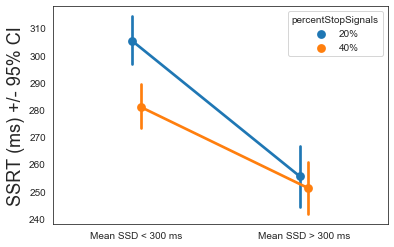

In [40]:
#plot 3b to aid visualization
sns.set_style('white')

sns.pointplot(x='MeanSSDBelowOrAbove300',
                  y='SSRT_ms',
                  hue='percentStopSignals',
                  data=data_3b_tidy,
                  dodge=True)

plt.xlabel('')
plt.ylabel('SSRT (ms) +/- 95% CI',fontsize=18)
plt.show()
_ = plt.close()

### SSRT x SSD

In [41]:
ssrt_comparison([cond11_df, cond12_df], ['Low', 'High'])

Low
1 subject(s) excluded from Low
Overall SSRT (M = 284 ms) was significantly slower than SSRT with short SSDs excluded (M = 275 ms),
t(337) = 8.45, p < 0.001
********************************************************************************
High
2 subject(s) excluded from High
Overall SSRT (M = 260 ms) was significantly slower than SSRT with short SSDs excluded (M = 252 ms),
t(336) = 6.10, p < 0.001
********************************************************************************


# Saccadic versus Manual Responses (Conditions 15 and 9)


In [42]:
cond15_df = read_cond_file('Data/DataSaccades.xlsx')
# shifting subject IDs to prevent confusion in following analyses
cond15_df.Subject += cond9_df.Subject.max()

In [43]:
effector_df = mk_anova_df([cond9_df, cond15_df], ['hand', 'eyes'])

saccade_ACC = effector_df.loc[effector_df.condition=='eyes', 'GoACC'].mean()
print(f'Saccadic go accuracy = {np.mean(saccade_ACC):.0%}')


# RT by probability Analysis
RTManSacc_melt_df = pd.melt(effector_df, id_vars=['subject', 'condition'], value_vars=['goRT', 'stopFailRT'], var_name='TrialType', value_name='RT')

Saccadic go accuracy = 99%


In [44]:
%%R -i RTManSacc_melt_df -o tbl #RUN ANOVA

aovres <- anova_test(
  data = RTManSacc_melt_df, dv = RT, wid = subject,
    within = TrialType,
    between = condition,
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [45]:
tbl = tbl.set_index('Effect')
groupProb_df = effector_df.groupby('condition').mean()
diff_hand = groupProb_df.loc['hand', 'goRT'] - groupProb_df.loc['hand', 'stopFailRT']
diff_eye = groupProb_df.loc['eyes', 'goRT'] - groupProb_df.loc['eyes', 'stopFailRT']

rt_by_prob_str = f'''A 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Effector: Hands vs. Eyes) mixed ANOVA on RT showed a main effect of manual versus saccades,
F({tbl.loc['condition', 'DFn']:.0f}, {tbl.loc['condition', 'DFd']:.0f}) = {tbl.loc['condition', 'F']:.1f},  {get_p_str(tbl.loc['condition', 'p'])}, with manual responses (M = {groupProb_df.loc['hand', ['goRT', 'stopFailRT']].mean():.0f}ms) slower than saccades (M = {groupProb_df.loc['eyes', ['goRT', 'stopFailRT']].mean():.0f}ms). 
There was also a main effect of no-stop-signal versus stop-failure, F({tbl.loc['TrialType', 'DFn']:.0f}, {tbl.loc['TrialType', 'DFd']:.0f}) = {tbl.loc['TrialType', 'F']:.1f},  {get_p_str(tbl.loc['TrialType', 'p'])},
with no-stop-signal RT (M = {effector_df['goRT'].mean():.0f} ms) slower than stop-failure RT (M = {effector_df['stopFailRT'].mean():.0f}ms), as expected with the race model. 
The interaction was not significant, F({tbl.loc['condition:TrialType', 'DFn']:.0f}, {tbl.loc['condition:TrialType', 'DFd']:.0f}) = {tbl.loc['condition:TrialType', 'F']:.3f}, {get_p_str(tbl.loc['condition:TrialType', 'p'])}.'''

print(rt_by_prob_str)
print(formats.BOLD + '*'*80 + formats.END)
tbl

A 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Effector: Hands vs. Eyes) mixed ANOVA on RT showed a main effect of manual versus saccades,
F(1, 33) = 107.1,  p < 0.001, with manual responses (M = 448ms) slower than saccades (M = 211ms). 
There was also a main effect of no-stop-signal versus stop-failure, F(1, 33) = 25.3,  p < 0.001,
with no-stop-signal RT (M = 383 ms) slower than stop-failure RT (M = 364ms), as expected with the race model. 
The interaction was not significant, F(1, 33) = 0.001, p = 0.97.
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
condition,1.0,33.0,107.143,6.780000e-12,*,0.759000
TrialType,1.0,33.0,25.251,1.710000e-05,*,0.021000
condition:TrialType,1.0,33.0,0.001,9.710000e-01,,0.000001


### SSRT x SSD

In [46]:
ssrt_comparison([cond9_df, cond15_df], ['Manual', 'Saccadic'])

Manual
0 subject(s) excluded from Manual
Overall SSRT (M = 232 ms) was significantly slower than SSRT with short SSDs excluded (M = 209 ms),
t(23) = 4.54, p < 0.001
********************************************************************************
Saccadic
3 subject(s) excluded from Saccadic
Overall SSRT (M = 82 ms) was  numerically but not statistically significantly slower than SSRT with short SSDs excluded (M = 77 ms),
t(7) = 0.29, p = 0.78
********************************************************************************


# __Auditory versus Visual Stop Signals (Conditions 16-19)__

In [47]:
cond16_df = read_cond_file('Data/DataBtwnSubjAuditory1.xlsx')
cond17_df = read_cond_file('Data/DataBtwnSubjAuditory2.xlsx')
cond18_df = read_cond_file('Data/DataBtwnSubjVisual1.xlsx')
cond19_df = read_cond_file('Data/DataBtwnSubjVisual2.xlsx')

#shift subjects for following analyses
cond17_df['Subject'] += cond16_df['Subject'].max()
cond18_df['Subject'] += cond17_df['Subject'].max()
cond19_df['Subject'] += cond18_df['Subject'].max()

In [48]:
AV_df = mk_anova_df([cond16_df, cond17_df, cond18_df, cond19_df], ['Auditory', 'Auditory', 'Visual', 'Visual'])

# RT by trialtype & modality Analysis
RTAV_melt_df = pd.melt(AV_df, id_vars=['subject', 'condition'], value_vars=['goRT', 'stopFailRT'], var_name='TrialType', value_name='RT')

In [49]:
%%R -i RTAV_melt_df -o tbl #RUN ANOVA

aovres <- anova_test(
  data = RTAV_melt_df, dv = RT, wid = subject,
    within = TrialType,
    between = condition,
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [50]:
tbl = tbl.set_index('Effect')
anova_str = f'''A 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop Modality: Auditory vs. Visual) mixed ANOVA on RTs was run.
The main effect of Trialtype was significant, F({tbl.loc['TrialType', 'DFn']:.0f}, {tbl.loc['TrialType', 'DFd']:.0f}) = {tbl.loc['TrialType', 'F']:.1f}, {get_p_str(tbl.loc['TrialType', 'p'])},
with no-stop-signal RT (M = {AV_df.goRT.mean():.0f} ms) longer than stop-failure RT (M = {AV_df.stopFailRT.mean():.0f} ms). '''

print(anova_str)
print(formats.BOLD + '*'*80 + formats.END)
tbl

A 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop Modality: Auditory vs. Visual) mixed ANOVA on RTs was run.
The main effect of Trialtype was significant, F(1, 102) = 475.0, p < 0.001,
with no-stop-signal RT (M = 607 ms) longer than stop-failure RT (M = 540 ms). 
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
condition,1.0,102.0,1.642,2.030000e-01,,0.016000
TrialType,1.0,102.0,475.042,3.590000e-40,*,0.066000
condition:TrialType,1.0,102.0,1.666,2.000000e-01,,0.000248


### SSRT x SSD

In [51]:
ssrt_comparison([cond16_df, cond17_df, cond18_df, cond19_df], ['Auditory 1', 'Auditory 2', 'Visual 1', 'Visual 2'])

Auditory 1
0 subject(s) excluded from Auditory 1
Overall SSRT (M = 194 ms) was significantly slower than SSRT with short SSDs excluded (M = 186 ms),
t(23) = 3.15, p = 0.004
********************************************************************************
Auditory 2
0 subject(s) excluded from Auditory 2
Overall SSRT (M = 206 ms) was significantly slower than SSRT with short SSDs excluded (M = 190 ms),
t(23) = 2.35, p = 0.03
********************************************************************************
Visual 1
0 subject(s) excluded from Visual 1
Overall SSRT (M = 216 ms) was significantly slower than SSRT with short SSDs excluded (M = 207 ms),
t(31) = 2.61, p = 0.01
********************************************************************************
Visual 2
0 subject(s) excluded from Visual 2
Overall SSRT (M = 222 ms) was significantly slower than SSRT with short SSDs excluded (M = 215 ms),
t(23) = 2.23, p = 0.04
****************************************************************************

In [52]:
del cond16_df
del cond17_df
del cond18_df
del cond19_df

# __Between-Subject Stimulus Selective vs. Simple Stopping (Condition 20 and 9)__

In [53]:
cond20_df = read_cond_file('Data/DataBtwnSubjStimSelec.xlsx')

#shifting subject IDs for analysis
cond20_df.Subject += cond9_df.Subject.max()

In [54]:
selective_df = mk_anova_df([cond20_df, cond9_df], ['Selective', 'Simple'])

# RT by trialtype & selective Analysis
RTselec_melt_df = pd.melt(selective_df, id_vars=['subject', 'condition'], value_vars=['goRT', 'stopFailRT'], var_name='TrialType', value_name='RT')


selective_RT = selective_df.loc[selective_df.condition=='Selective', ['goRT', 'stopFailRT']].mean().mean()
simple_RT = selective_df.loc[selective_df.condition=='Simple', ['goRT', 'stopFailRT']].mean().mean()

In [55]:
%%R -i RTselec_melt_df -o tbl #RUN ANOVA

aovres <- anova_test(
  data = RTselec_melt_df, dv = RT, wid = subject,
    within = TrialType,
    between = condition,
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [56]:
tbl = tbl.set_index('Effect')

anova_str=f'''To evaluate the race model in these data, a 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop Task: Simple vs. Stimulus selective) mixed ANOVA on RT was run. 
Both main effects were significant, with no-stop-signal RT (M = {selective_df.goRT.mean():.0f} ms) being slower than stop-failure RT (M = {selective_df.stopFailRT.mean():.0f} ms), F({tbl.loc['TrialType', 'DFn']:.0f}, {tbl.loc['TrialType', 'DFd']:.0f}) = {tbl.loc['TrialType', 'F']:.1f}, {get_p_str(tbl.loc['TrialType', 'p'])}, 
and RT in the selective stopping task (M = {selective_RT:.0f} ms) being slower than RT in the simple stopping task (M = {simple_RT:.0f} ms),
F({tbl.loc['condition', 'DFn']:.0f}, {tbl.loc['condition', 'DFd']:.0f}) = {tbl.loc['condition', 'F']:.1f}, {get_p_str(tbl.loc['condition', 'p'])}.
However, the interaction was not significant, F({tbl.loc['condition:TrialType', 'DFn']:.0f}, {tbl.loc['condition:TrialType', 'DFd']:.0f}) = {tbl.loc['condition:TrialType', 'F']:.1f}, {get_p_str(tbl.loc['condition:TrialType', 'p'])}.'''

print(anova_str)
print(formats.BOLD + '*'*80 + formats.END)
tbl

To evaluate the race model in these data, a 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop Task: Simple vs. Stimulus selective) mixed ANOVA on RT was run. 
Both main effects were significant, with no-stop-signal RT (M = 503 ms) being slower than stop-failure RT (M = 491 ms), F(1, 46) = 7.8, p = 0.01, 
and RT in the selective stopping task (M = 546 ms) being slower than RT in the simple stopping task (M = 448 ms),
F(1, 46) = 20.7, p < 0.001.
However, the interaction was not significant, F(1, 46) = 2.2, p = 0.14.
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
condition,1.0,46.0,20.665,0.00004,*,0.301
TrialType,1.0,46.0,7.779,0.00800,*,0.007
condition:TrialType,1.0,46.0,2.243,0.14100,,0.002


In [57]:
#GET STRATEGY LABELS FOR COND20 PARTICIPANTS
strat_dict = {}
for subject in cond20_df.Subject.unique():
    subdata = cond20_df.query('Subject == %d' % subject).copy()
    # Get distribution of goRTs, signalRespondRTs, and ignoreRTs for t-tests and subsequent BayeFactor
    goRTs = subdata.loc[(subdata['TrialType']=='go') & (subdata['GoRT']>0), 'GoRT'].values.copy()
    signalRespondRTs = subdata.loc[(subdata['TrialType']=='stop') & (subdata['StopFailureRT']>0), 'StopFailureRT'].values.copy()
    ignoreRTs = subdata.loc[(subdata['TrialType']=='ignore') & (subdata['IgnoreRT']>0), 'IgnoreRT'].values.copy()
    
    # stopfail vs go
    t_signalRespond_v_noSignal, _ = stats.ttest_ind(signalRespondRTs, goRTs)
    bayes_out_signalRespond = BayesFactor.ttest_tstat(t=float(t_signalRespond_v_noSignal),
                                                  n1=len(signalRespondRTs),
                                                  n2=len(goRTs), rscale = 1) #using 1 as in the 2014 paper
    bf_signalRespond = math.exp(get_attr(bayes_out_signalRespond))
    
    # ignore vs go
    t_ignore_v_noSignal, _ = stats.ttest_ind(ignoreRTs, goRTs)
    bayes_out_ignore = BayesFactor.ttest_tstat(t=float(t_ignore_v_noSignal),
                                                      n1=len(ignoreRTs),
                                                      n2=len(goRTs), rscale = 1) #using 1 as in the 2014 paper
    bf_ignore = math.exp(get_attr(bayes_out_ignore))
    
    #label - criteria is bf >1 + direction is correct (bf is not directional)
    if (np.abs(bf_ignore) > 1) & (np.mean(ignoreRTs)>np.mean(goRTs)):
        if (np.abs(bf_signalRespond) > 1) & (np.mean(goRTs)>np.mean(signalRespondRTs)): 
            strat_dict[subject] = 'SD'
        else:
            strat_dict[subject] = 'DDS'
    else:
        strat_dict[subject] = 'uncategorized/IDS'


###################################################################################################
# Generate a DF that has every stop trial which had a previous Go trial, contains the previous goRT
verbose = False
go_key = 'GoRT'


stop_trials_w_matchingGo = None
for subject in cond20_df.Subject.unique():
    subdata = cond20_df.query('Subject == %d' % subject).copy()
    if verbose: print('subject %d: found %d trials' % (subject, subdata.shape[0]))
    ssdvals = [i for i in subdata.StopSignalDelay.unique() if isinstance(i, float) and i >=0] #ignore nan/missing values and 0/negative SSDs
    ssdvals.sort()

    # You find all pairs of trials in which the first is a go trials with a response and the second is a 
    # stop trial with a response. Both trials need to come from the same subject and block. 
    # This should be done separately for each SSD. Then the RT for the first trial in the pair should be 
    # subtracted from the second. This is the core analysis per SSD per subject.

    for ssd in ssdvals:
        ssd_data = subdata.query('StopSignalDelay == %d' % ssd).copy()
        signal_respond_data = ssd_data.dropna(subset=["StopFailureRT"])
        signal_respond_data = signal_respond_data.loc[signal_respond_data['StopFailureRT'] > 0, :]
        # for each signal respond trial, determine whether the previous trial was a go trial in the same block
        signal_respond_data['MatchingGo'] = np.nan
        if signal_respond_data.shape[0] > 0:
            for t in signal_respond_data.index:
                if t < 1:
                    continue
                prevtrial = cond20_df.loc[int(t) - 1, :]
                if prevtrial.Block == signal_respond_data.loc[t, 'Block']:
                    # blockmatch
                    signal_respond_data.loc[t, 'MatchingGo'] = prevtrial[go_key]
            signal_respond_data = signal_respond_data.dropna(subset=['MatchingGo'])
            if stop_trials_w_matchingGo is None:
                stop_trials_w_matchingGo = signal_respond_data
            else:
                stop_trials_w_matchingGo = pd.concat([stop_trials_w_matchingGo, signal_respond_data], axis=0)
                
                
#Build up pertinent data for each subject: StopFailRTAtShorterSSDs, StopFailRTAtLongerSSDs, PrecedingNoStopRTAtShorterSSDs, PrecedingNoStopRTAtLongerSSDs
stopFailRTs_shortSSDs = []
stopFailRTs_longSSDs = []
precedingNoStopRTs_shortSSDs = []
precedingNoStopRTs_longSSDs = []

for subject in cond20_df.Subject.unique():
    subdata = stop_trials_w_matchingGo.query('Subject == %d' % subject).copy()
    
    shortSSD_df = subdata.loc[subdata.StopSignalDelay<250]
    stopFailRTs_shortSSDs.append(shortSSD_df['StopFailureRT'].mean())
    precedingNoStopRTs_shortSSDs.append(shortSSD_df['MatchingGo'].mean())
    
    longSSD_df = subdata.loc[subdata.StopSignalDelay>250]
    stopFailRTs_longSSDs.append(longSSD_df['StopFailureRT'].mean())
    precedingNoStopRTs_longSSDs.append(longSSD_df['MatchingGo'].mean())

R[write to console]: t is large; approximation invoked.



In [58]:
#Combine into a single df
fig3c_shortSSD_df = pd.DataFrame({'subject': cond20_df.Subject.unique(), 
                                  'mean_stopFailureRT': stopFailRTs_shortSSDs,
                                  'mean_precedingGoRT': precedingNoStopRTs_shortSSDs,
                                  'SSD': '< 250',
                                  'strategy': [strat_dict[sub] for sub in cond20_df.Subject.unique()]})

fig3c_longSSD_df = pd.DataFrame({'subject': cond20_df.Subject.unique(), 
                                  'mean_stopFailureRT': stopFailRTs_longSSDs,
                                  'mean_precedingGoRT': precedingNoStopRTs_longSSDs,
                                  'SSD': '> 250',
                                  'strategy': [strat_dict[sub] for sub in cond20_df.Subject.unique()]})

rt_by_ssd_df = pd.concat([fig3c_shortSSD_df, fig3c_longSSD_df])
rt_by_ssd_df = rt_by_ssd_df.dropna()
cond20_melt_df = pd.melt(rt_by_ssd_df, id_vars=['subject', 'SSD', 'strategy'], value_vars=['mean_stopFailureRT', 'mean_precedingGoRT'], var_name='TrialType', value_name='RT')

In [59]:
%%R -i cond20_melt_df -o c20_tbl # RUN ANOVA - this is equivalent to JASP

library(rstatix)
aovres <- anova_test(
  data = cond20_melt_df, dv = RT, wid = subject,
  between = strategy, within = c(SSD, TrialType),
    type="3"
  )
c20_tbl = get_anova_table(aovres)

In [60]:
# Save fig3c_df for JASP
fig3c_df = pd.concat([fig3c_shortSSD_df.add_prefix('short_'), fig3c_longSSD_df.add_prefix('long_')], axis=1)
fig3c_df.dropna()
fig3c_df.to_csv(path.join(F2_INPUT_DIR, 'fig3cInput.csv'), index=False)

c20_tbl = c20_tbl.set_index('Effect')

# η2 values retrieved from Fig3Jasp/fig3cOutput.jasp
strategy_eta = 0.018
SSD_eta = 1.073e-4
trialType_eta = 0.005
strategyXSSD_eta = 7.834e-4
strategyXtrialType_eta = 8.412e-5
SSDXtrialType_eta = 0.071
fullInteraction_eta = 0.04


cond20_str=f''' We ran a 2 (Trialtype: Stop-failure vs. Preceding no-stop) x 2 (SSD: Shorter <250ms vs. Longer >250ms) x 2 (Strategy: Stop then Discriminate vs. Dependent Discriminate then Stop)
mixed ANOVA on RT with the first two factors within-subjects and the last factor between-subjects. 250ms is similar to the mean SSD (239 ms)
and was chosen to try to ensure a sufficient number of trials in the shorter and longer SSD levels of the SSD factor.
There were no significant main effects or interactions (all p’s > .36) other than the 2-way interaction of Trialtype and SSD, F({c20_tbl.loc['SSD:TrialType', 'DFn']}, {c20_tbl.loc['SSD:TrialType', 'DFd']}) = {c20_tbl.loc['SSD:TrialType', 'F']}, {get_p_str(c20_tbl.loc['SSD:TrialType', 'p'])}, η2 = {SSDXtrialType_eta:.3f}. Importantly, there was no 3-way interaction...'''
print(cond20_str)
print(formats.BOLD + '*'*80 + formats.END)
c20_tbl

 We ran a 2 (Trialtype: Stop-failure vs. Preceding no-stop) x 2 (SSD: Shorter <250ms vs. Longer >250ms) x 2 (Strategy: Stop then Discriminate vs. Dependent Discriminate then Stop)
mixed ANOVA on RT with the first two factors within-subjects and the last factor between-subjects. 250ms is similar to the mean SSD (239 ms)
and was chosen to try to ensure a sufficient number of trials in the shorter and longer SSD levels of the SSD factor.
There were no significant main effects or interactions (all p’s > .36) other than the 2-way interaction of Trialtype and SSD, F(1.0, 20.0) = 12.115, p = 0.002, η2 = 0.071. Importantly, there was no 3-way interaction...
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
strategy,1.0,20.0,0.688,0.417,,0.020000
SSD,1.0,20.0,0.014,0.906,,0.000119
TrialType,1.0,20.0,0.868,0.363,,0.005000
strategy:SSD,1.0,20.0,0.105,0.749,,0.000868
strategy:TrialType,1.0,20.0,0.016,0.901,,0.000093
SSD:TrialType,1.0,20.0,12.115,0.002,*,0.073000
strategy:SSD:TrialType,1.0,20.0,0.603,0.446,,0.004000


### SSRT x SSD

In [61]:
ssrt_comparison([cond20_df, cond9_df], ['Selective', 'Simple'])

Selective
0 subject(s) excluded from Selective
Overall SSRT (M = 289 ms) was significantly slower than SSRT with short SSDs excluded (M = 245 ms),
t(23) = 3.53, p = 0.002
********************************************************************************
Simple
0 subject(s) excluded from Simple
Overall SSRT (M = 232 ms) was significantly slower than SSRT with short SSDs excluded (M = 209 ms),
t(23) = 4.54, p < 0.001
********************************************************************************


In [62]:
del cond20_df
del cond9_df

# __Online Within-Subject Stimulus Selective vs. Simple Stopping (Condition 11-13)__

In [63]:
cond13_df = read_cond_file('Data/DataTurkStimSelec.xlsx')

In [64]:
online_df = mk_anova_df([cond11_df, cond12_df, cond13_df], ['low', 'high', 'selective'])

In [65]:
low_df = online_df.loc[online_df['condition']=='low']
high_df = online_df.loc[online_df['condition']=='high']
conds1112_df = pd.concat([low_df, high_df])
conds1112_df = conds1112_df.groupby('subject').mean()

selective_df = online_df.loc[online_df['condition']=='selective']
selective_df.set_index('subject', inplace=True)

t_rt, p_rt = stats.ttest_1samp(selective_df['corrGoRT']-conds1112_df['corrGoRT'], 0)
t_acc, p_acc = stats.ttest_1samp(selective_df['GoACC']-conds1112_df['GoACC'], 0)

intial_comparison_str=f'''Correct no-signal RT was faster in the simple stop conditions (M = {conds1112_df.mean()['corrGoRT']:.0f} ms)
than in the stimulus selective stopping condition (M = {selective_df.mean()['corrGoRT']:.0f} ms), t({len(selective_df['corrGoRT'])-1}) = {t_rt:.2f}, {get_p_str(p_rt)}.
No-signal was slightly higher in the stimulus selective stopping condition (M = {selective_df.mean()['GoACC']:.1%})
than the simple condition (M = {conds1112_df.mean()['GoACC']:.1%}), t({len(selective_df['GoACC'])-1}) = {t_acc:.2f}, {get_p_str(p_acc)}.'''
print(intial_comparison_str)

# 2x2 ANOVA
conds1112_df['condition']='simple'
onlineSelective_df = pd.concat([conds1112_df, selective_df])
onlineSelective_df.reset_index(inplace=True) #move subject from index to column
# RT by trialtype & modality Analysis
RTonline_melt_df = pd.melt(onlineSelective_df, id_vars=['subject', 'condition'], value_vars=['goRT', 'stopFailRT'], var_name='TrialType', value_name='RT')

interaction_df = onlineSelective_df.groupby('condition').mean()

Correct no-signal RT was faster in the simple stop conditions (M = 588 ms)
than in the stimulus selective stopping condition (M = 613 ms), t(338) = 5.24, p < 0.001.
No-signal was slightly higher in the stimulus selective stopping condition (M = 95.2%)
than the simple condition (M = 94.7%), t(338) = 2.13, p = 0.03.


In [66]:
%%R -i RTonline_melt_df -o tbl #RUN ANOVA

aovres <- anova_test(
  data = RTonline_melt_df, dv = RT, wid = subject,
    within = c(TrialType,condition),
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [67]:
tbl = tbl.set_index('Effect')
anova_str=f'''In order to evaluate the race model in these data, we ran 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop Type: Simple vs. Stimulus selective) repeated-measures ANOVA on RT.
Both main effects were significant, with no-stop-signal RT (M = {RTonline_melt_df[RTonline_melt_df['TrialType']=='goRT'].RT.mean():.0f} ms) being slower than stop-failure RT (M = {RTonline_melt_df[RTonline_melt_df['TrialType']=='stopFailRT'].RT.mean():.0f} ms), F({tbl.loc['TrialType', 'DFn']}, {tbl.loc['TrialType', 'DFd']}) = {tbl.loc['TrialType', 'F']:.1f}, {get_p_str(tbl.loc['TrialType', 'p'])},
and RT in the stimulus selective stopping task (M = {RTonline_melt_df.loc[RTonline_melt_df.condition=='selective', 'RT'].mean():.0f} ms) being slower than RT in the simple stopping task (M = {RTonline_melt_df.loc[RTonline_melt_df.condition=='simple', 'RT'].mean():.0f} ms), F({tbl.loc['condition', 'DFn']}, {tbl.loc['condition', 'DFd']}) = {tbl.loc['condition', 'F']:.1f}, {get_p_str(tbl.loc['condition', 'p'])}.
The interaction was also significant, F({tbl.loc['TrialType:condition', 'DFn']}, {tbl.loc['TrialType:condition', 'DFd']}) = {tbl.loc['TrialType:condition', 'F']:.1f}, {get_p_str(tbl.loc['TrialType:condition', 'p'])}, as the stop-failure minus no-stop-signal difference was larger in the simple (M = {(interaction_df['stopFailRT'] - interaction_df['goRT'])['simple']:.0f} ms)
than the stimulus selective (M = {(interaction_df['stopFailRT'] - interaction_df['goRT'])['selective']:.0f} ms) stopping condition.'''
print(anova_str)
print(formats.BOLD+'*'*80+formats.END)
tbl

In order to evaluate the race model in these data, we ran 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop Type: Simple vs. Stimulus selective) repeated-measures ANOVA on RT.
Both main effects were significant, with no-stop-signal RT (M = 601 ms) being slower than stop-failure RT (M = 570 ms), F(1.0, 338.0) = 339.6, p < 0.001,
and RT in the stimulus selective stopping task (M = 602 ms) being slower than RT in the simple stopping task (M = 569 ms), F(1.0, 338.0) = 64.4, p < 0.001.
The interaction was also significant, F(1.0, 338.0) = 38.4, p < 0.001, as the stop-failure minus no-stop-signal difference was larger in the simple (M = -38 ms)
than the stimulus selective (M = -22 ms) stopping condition.
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
TrialType,1.0,338.0,339.639,5.420000e-53,*,0.034
condition,1.0,338.0,64.397,1.690000e-14,*,0.040
TrialType:condition,1.0,338.0,38.411,1.670000e-09,*,0.002


In [68]:
ssrt_comparison([cond13_df], ['online selective'])

online selective
1 subject(s) excluded from online selective
Overall SSRT (M = 299 ms) was significantly slower than SSRT with short SSDs excluded (M = 278 ms),
t(337) = 11.22, p < 0.001
********************************************************************************


# __In Lab Within-Subject Stimulus Selective vs. Simple Stopping (Conditions 21-24)__

In [69]:
cond21_df = read_cond_file('Data/DataWithinSubjCentralGoSimple.xlsx')
cond22_df = read_cond_file('Data/DataWithinSubjCentralGoSelec.xlsx')
cond23_df = read_cond_file('Data/DataWithinSubjPeriphGoSimple.xlsx')
cond24_df = read_cond_file('Data/DataWithinSubjPeriphGoSelec.xlsx')

In [70]:
inlab_df = mk_anova_df([cond21_df, cond22_df, cond23_df, cond24_df], ['central simple', 'central selective', 'peripheral simple', 'peripheral selective'])
inlab_df[['location', 'condition']] = inlab_df.condition.str.split(expand=True) 

RTinLab_melt_df = pd.melt(inlab_df, id_vars=['subject', 'condition', 'location'], value_vars=['goRT', 'stopFailRT'], var_name='TrialType', value_name='RT')

In [71]:
%%R -i RTinLab_melt_df -o tbl #RUN ANOVA

aovres <- anova_test(
  data = RTinLab_melt_df, dv = RT, wid = subject,
    within = c(TrialType,condition,location),
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [72]:
tbl = tbl.set_index('Effect')

grRT_df = RTinLab_melt_df.groupby('TrialType').mean()

mi_rt_df = RTinLab_melt_df.groupby(['condition', 'TrialType']).mean()

simple_diff = mi_rt_df.loc['simple'].loc['goRT', 'RT'] - mi_rt_df.loc['simple'].loc['stopFailRT', 'RT']
selective_diff = mi_rt_df.loc['selective'].loc['goRT', 'RT'] - mi_rt_df.loc['selective'].loc['stopFailRT', 'RT']

inlab_str=f'''A 2 (Stop Type: Simple vs. Stimulus selective) x 2 (Go Location: Central vs. Peripheral) x 2 (Trialtype: No-stop-signal vs. Stop-failure)
repeated-measures ANOVA on RT was run. There were no significant main effects of simple versus selective or central versus peripheral,
and those two variables did not interact, showing that RT was similar across simple and selective stopping and central and peripheral go stimuli.
There was a significant main effect of no-stop-signal RT versus stop-failure RT, F({tbl.loc['TrialType', 'DFn']:.0f}, {tbl.loc['TrialType', 'DFd']:.0f}) = {tbl.loc['TrialType', 'F']:.1f}, {get_p_str(tbl.loc['TrialType', 'p'])},
as no-stop-signal RT (M = {grRT_df.loc['goRT', 'RT']:.0f} ms) was longer than stop-failure RT (M = {grRT_df.loc['stopFailRT', 'RT']:.0f} ms).
There was also a significant interaction between selective versus simple and no-stop-signal RT versus stop-failure RT, F({tbl.loc['TrialType:condition', 'DFn']:.0f}, {tbl.loc['TrialType:condition', 'DFd']:.0f}) = {tbl.loc['TrialType:condition', 'F']:.1f}, {get_p_str(tbl.loc['TrialType:condition', 'p'])},
with a larger difference between no-stop-signal RT and stop-failure RT in the simple conditions (M = {simple_diff:.0f} ms) than in the selective conditions (M = {selective_diff:.0f} ms).'''
print(inlab_str)
print(formats.BOLD+'*'*80+formats.END)
tbl

A 2 (Stop Type: Simple vs. Stimulus selective) x 2 (Go Location: Central vs. Peripheral) x 2 (Trialtype: No-stop-signal vs. Stop-failure)
repeated-measures ANOVA on RT was run. There were no significant main effects of simple versus selective or central versus peripheral,
and those two variables did not interact, showing that RT was similar across simple and selective stopping and central and peripheral go stimuli.
There was a significant main effect of no-stop-signal RT versus stop-failure RT, F(1, 23) = 29.2, p < 0.001,
as no-stop-signal RT (M = 477 ms) was longer than stop-failure RT (M = 453 ms).
There was also a significant interaction between selective versus simple and no-stop-signal RT versus stop-failure RT, F(1, 23) = 19.7, p < 0.001,
with a larger difference between no-stop-signal RT and stop-failure RT in the simple conditions (M = 35 ms) than in the selective conditions (M = 13 ms).
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
TrialType,1.0,23.0,29.198,0.000017,*,0.009000
condition,1.0,23.0,1.091,0.307000,,0.002000
location,1.0,23.0,2.340,0.140000,,0.016000
TrialType:condition,1.0,23.0,19.662,0.000191,*,0.002000
TrialType:location,1.0,23.0,1.579,0.221000,,0.000436
condition:location,1.0,23.0,3.012,0.096000,,0.002000
TrialType:condition:location,1.0,23.0,0.015,0.905000,,0.000001


### SSRT x SSD

In [73]:
ssrt_comparison([cond21_df, cond22_df, cond23_df, cond24_df], ['central simple', 'central selective', 'peripheral simple', 'peripheral selective'])

central simple
1 subject(s) excluded from central simple
Overall SSRT (M = 200 ms) was significantly slower than SSRT with short SSDs excluded (M = 194 ms),
t(22) = 2.74, p = 0.01
********************************************************************************
central selective
1 subject(s) excluded from central selective
Overall SSRT (M = 257 ms) was significantly slower than SSRT with short SSDs excluded (M = 213 ms),
t(22) = 3.67, p = 0.001
********************************************************************************
peripheral simple
2 subject(s) excluded from peripheral simple
Overall SSRT (M = 201 ms) was significantly slower than SSRT with short SSDs excluded (M = 185 ms),
t(21) = 2.77, p = 0.01
********************************************************************************
peripheral selective
1 subject(s) excluded from peripheral selective
Overall SSRT (M = 243 ms) was significantly slower than SSRT with short SSDs excluded (M = 200 ms),
t(22) = 4.84, p < 0.001
***********

In [74]:
del cond13_df
del cond21_df
del cond22_df
del cond23_df
del cond24_df

# __Online Within-Subject Motor Selective vs. Simple Stopping (Conditions 11, 12, and 14)__

In [75]:
cond14_df = read_cond_file('Data/DataTurkMotorSelec.xlsx')

In [76]:
critical_RTs = []
critical_ACCs = []
noncritical_RTs = []
noncritical_ACCs = [] 
for subject in full_passed_turkers:
    subdata = cond14_df.query('Subject == %d' % subject).copy()
    crit_RT = get_mean_corr_RT(subdata, trial_type='GoCritical')
    noncrit_RT = get_mean_corr_RT(subdata, trial_type='GoNoncritical')
    crit_ACC = get_acc(subdata, trial_type='GoCritical')
    noncrit_ACC = get_acc(subdata, trial_type='GoNoncritical')
    
    critical_RTs.append(crit_RT)
    noncritical_RTs.append(noncrit_RT)
    critical_ACCs.append(crit_ACC)
    noncritical_ACCs.append(noncrit_ACC)
    
print(f'mean correct non-critical Go RT = {np.mean(noncritical_RTs): .0f}ms')
print(f'mean correct critical Go RT = {np.mean(critical_RTs): .0f}ms')
t_rt, p_rt = stats.ttest_1samp(np.asarray(noncritical_RTs)-np.asarray(critical_RTs), 0)
print(f't({len(noncritical_RTs)-1})={t_rt: .1f}, {get_p_str(p_rt)})')
print(formats.BOLD + '*'*80 + formats.END)
print(f'mean non-critical Go ACC = {np.mean(noncritical_ACCs): .1%}ms')
print(f'mean critical Go ACC = {np.mean(critical_ACCs): .1%}ms')
t_acc, p_acc = stats.ttest_1samp(np.asarray(noncritical_ACCs)-np.asarray(critical_ACCs), 0)
print(f't({len(noncritical_RTs)-1})={t_acc: .1f}, {get_p_str(p_acc)})')
print(formats.BOLD + '*'*80 + formats.END)

#get RT, ACC for each subject in both 11 and 12, average
RTs = []
ACCs = []
for subject in full_passed_turkers:
    subdata11 = cond11_df.query('Subject == %d' % subject).copy()
    RT11 = get_mean_corr_RT(subdata11, trial_type='Go')
    ACC11 = get_acc(subdata11, trial_type='Go')
    
    subdata12 = cond12_df.query('Subject == %d' % subject).copy()
    RT12 = get_mean_corr_RT(subdata12, trial_type='Go')
    ACC12 = get_acc(subdata12, trial_type='Go')
    
    RTs.append(np.mean([RT11, RT12]))
    ACCs.append(np.mean([ACC11, ACC12]))

print(f'mean motor selective correct critical Go RT  = {np.mean(critical_RTs): .0f}ms')
print(f'mean simple correct Go RT  = {np.mean(RTs): .0f}ms')
t_simpSelec_rt, p_simpSelec_rt = stats.ttest_1samp(np.asarray(critical_RTs)-np.asarray(RTs), 0)
print(f't({len(critical_RTs)-1})={t_simpSelec_rt: .2f}, {get_p_str(p_simpSelec_rt)})')
print(formats.BOLD + '*'*80 + formats.END)

print(f'mean motor selective correct critical Go ACC = {np.mean(critical_ACCs): .1%}ms')
print(f'mean simple correct Go ACC = {np.mean(ACCs): .1%}ms')
t_simpSelec_acc, p_simpSelec_acc = stats.ttest_1samp(np.asarray(critical_ACCs)-np.asarray(ACCs), 0)
print(f't({len(critical_RTs)-1})={t_simpSelec_acc: .2f}, {get_p_str(p_simpSelec_acc)})')


mean correct non-critical Go RT =  529ms
mean correct critical Go RT =  611ms
t(338)=-24.4, p < 0.001)
********************************************************************************
mean non-critical Go ACC =  96.2%ms
mean critical Go ACC =  92.6%ms
t(338)= 12.4, p < 0.001)
********************************************************************************
mean motor selective correct critical Go RT  =  611ms
mean simple correct Go RT  =  588ms
t(338)= 6.03, p < 0.001)
********************************************************************************
mean motor selective correct critical Go ACC =  92.6%ms
mean simple correct Go ACC =  94.7%ms
t(338)=-7.24, p < 0.001)


In [77]:
simpleMotorSelec_anova_df = mk_anova_df([cond11_df, cond12_df, cond14_df], ['11', '12', 'motor'])

# pull out and average conditions 11 and 12
summary11_df = simpleMotorSelec_anova_df.loc[simpleMotorSelec_anova_df.condition=='11']
summary12_df = simpleMotorSelec_anova_df.loc[simpleMotorSelec_anova_df.condition=='12']
summary1112_df = pd.concat([summary11_df, summary12_df]).groupby('subject').mean()
#fix indices, condition
summary1112_df.reset_index(inplace=True)
summary1112_df['condition'] = 'simple'

#recombine
simpleMotorSelec_anova_df = pd.concat([summary1112_df, simpleMotorSelec_anova_df.loc[simpleMotorSelec_anova_df.condition=='motor']], sort=True)

In [78]:
RTmotor_melt_df = pd.melt(simpleMotorSelec_anova_df, id_vars=['subject', 'condition'], value_vars=['goRT', 'stopFailRT'], var_name='TrialType', value_name='RT')

twoByTwoResults_df = RTmotor_melt_df.groupby(['condition', 'TrialType']).mean()

motorInteraction = twoByTwoResults_df.loc[( 'motor', 'goRT'), 'RT'] - twoByTwoResults_df.loc[( 'motor', 'stopFailRT'), 'RT']
simpleInteraction = twoByTwoResults_df.loc[( 'simple', 'goRT'), 'RT'] - twoByTwoResults_df.loc[( 'simple', 'stopFailRT'), 'RT']

In [79]:
%%R -i RTmotor_melt_df -o tbl #RUN ANOVA

aovres <- anova_test(
  data = RTmotor_melt_df, dv = RT, wid = subject,
    within = c(TrialType,condition),
    type="3",
  )
tbl = get_anova_table(aovres, correction="none")

In [80]:
tbl = tbl.set_index('Effect')
motorSelec_anova_str=f'''we ran 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop type: Simple vs. Motor selective) repeated-measures ANOVA on RT.
Both main effects and the interaction were significant. No-stop-signal RT (M = {simpleMotorSelec_anova_df.goRT.mean():.0f} ms) was slower than stop-failure RT (M = {simpleMotorSelec_anova_df.stopFailRT.mean():.0f} ms),
F({tbl.loc['TrialType', 'DFn']:.0f}, {tbl.loc['TrialType', 'DFd']:.0f}) = {tbl.loc['TrialType', 'F']:.1f}, {get_p_str(tbl.loc['TrialType', 'p'])},
and RT from the critical response of the motor selective stopping task (M = {RTmotor_melt_df.loc[RTmotor_melt_df.condition=='motor', 'RT'].mean():.0f} ms) was slower than RT in the simple stopping task (M = {RTmotor_melt_df.loc[RTmotor_melt_df.condition=='simple', 'RT'].mean():.0f} ms),
F({tbl.loc['condition', 'DFn']:.0f}, {tbl.loc['condition', 'DFd']:.0f}) = {tbl.loc['condition', 'F']:.1f}, {get_p_str(tbl.loc['condition', 'p'])}.
Finally, the no-stop-signal minus stop-failure difference was larger in the simple (M = {simpleInteraction:.0f} ms) than the motor selective (M = {motorInteraction:.0f} ms) stopping condition,
F({tbl.loc['TrialType:condition', 'DFn']:.0f}, {tbl.loc['TrialType:condition', 'DFd']:.0f}) = {tbl.loc['TrialType:condition', 'F']:.1f}, {get_p_str(tbl.loc['TrialType:condition', 'p'])}.'''
print(motorSelec_anova_str)
print(formats.BOLD + '*'*80 + formats.END)

tbl

we ran 2 (Trialtype: No-stop-signal vs. Stop-failure) x 2 (Stop type: Simple vs. Motor selective) repeated-measures ANOVA on RT.
Both main effects and the interaction were significant. No-stop-signal RT (M = 597 ms) was slower than stop-failure RT (M = 567 ms),
F(1, 338) = 357.3, p < 0.001,
and RT from the critical response of the motor selective stopping task (M = 595 ms) was slower than RT in the simple stopping task (M = 569 ms),
F(1, 338) = 56.4, p < 0.001.
Finally, the no-stop-signal minus stop-failure difference was larger in the simple (M = 38 ms) than the motor selective (M = 23 ms) stopping condition,
F(1, 338) = 37.6, p < 0.001.
********************************************************************************


,DFn,DFd,F,p,p<.05,ges
Effect,,,,,,
TrialType,1.0,338.0,357.325,6.880000e-55,*,0.041
condition,1.0,338.0,56.402,5.310000e-13,*,0.030
TrialType:condition,1.0,338.0,37.556,2.470000e-09,*,0.003


### SSRT x SSD Comparison

In [81]:
ssrt_comparison([cond14_df], ['online motor selective'])

online motor selective
0 subject(s) excluded from online motor selective
Overall SSRT (M = 322 ms) was significantly slower than SSRT with short SSDs excluded (M = 291 ms),
t(338) = 15.03, p < 0.001
********************************************************************************


In [82]:
del cond11_df
del cond12_df
del cond14_df

# __Variable Difficulty (condition 25)__

In [83]:
cond25_df = read_cond_file('Data/DataMatzke.xlsx')

In [84]:
ssrt_comparison([cond25_df], ['Variable Difficulty'])

Variable Difficulty
0 subject(s) excluded from Variable Difficulty
Overall SSRT (M = 340 ms) was significantly slower than SSRT with short SSDs excluded (M = 306 ms),
t(52) = 8.43, p < 0.001
********************************************************************************
